# Bayes by Backprop

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('GPU device not found. Using CPU')
else:
  print('Found GPU: {}'.format(tf.test.gpu_device_name()))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Tensorflow Version: 1.13.1
Tensorflow Probability Version: 0.6.0
Found GPU: /device:GPU:0


In [2]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [4]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

x_train, y_train, x_test, y_test = (x_train, y_train, x_test, y_test)

In [5]:
# Bayes by Backprop parameters

# model save file
model_save_file = "./models/bayes_by_backprop.h5"

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the number of neurons
n_hidden = [32, 32]

# batch size for training
batch_size = 128

# training epochs 
epochs = 3

# GloVe Word Embedding

In [6]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [7]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# Model

In [9]:
# TODO: use DistributionLambda
def create_model():
    model = tfk.Sequential()
    
    model.add(tfkl.Embedding(len(word_index.index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    
    for i in range(len(n_hidden)):
        model.add(tfpl.DenseFlipout(n_hidden[i], activation='relu'))
        #model.add(tfkl.Dense(n_hidden[i], activation="relu"))
    
    model.add(tfkl.Flatten())
    #model.add(tfkl.Dense(1))
    model.add(tfpl.DenseFlipout(1))
    
    return model

try:
    model = tfk.models.load_model(model_save_file)
    print("using saved model")
except:
    model = create_model()
    print("model has not been trained")
model.summary()

model has not been trained
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2697, 50)          4429400   
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 2697, 32)          3232      
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 2697, 32)          2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 86304)             0         
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 1)                 172609    
Total params: 4,607,321
Trainable params: 177,921
Non-trainable params: 4,429,400
_________________________________________________________________


In [ ]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb

loss = lambda y, rv_y: tf.nn.softmax_cross_entropy_with_logits_v2(y, rv_y) # -rv_y.log_prob(y)
# negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tfk.optimizers.Adam(0.0001), loss=loss, metrics=['acc'])
model.fit(x_train_padded, y_train, batch_size=batch_size, epochs=epochs, verbose=True)

Epoch 1/3
25000/25000 [==============================] - 4s 160us/sample - loss: 0.3737 - acc: 0.6977
Epoch 2/3
  512/25000 [..............................] - ETA: 3s - loss: 0.4173 - acc: 0.6934

In [63]:
# https://qiita.com/takeshikondo/items/46659a120f0af7ec2cca

x = tf.placeholder(shape=x_train_padded.shape, dtype=tf.float32)
y = tf.placeholder(shape=(batch_size, 1), dtype=tf.int32)

x_test_tf = tf.placeholder(shape=x_train_padded.shape, dtype=tf.float32)

logits = model(x)
neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=y, logits=logits)
kl = tf.reduce_mean(model.losses)
elbo_loss = neg_log_likelihood + kl

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(elbo_loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        
        yyy = sess.run(tf.expand_dims(y_train, 1))
        feed_dict = {
            x: x_train_padded, 
            y: yyy
        }
        sess.run(train_op, feed_dict=feed_dict)
        loss_train = sess.run(elbo_loss, feed_dict=feed_dict)
        #acc_train = sess.run(accuracy, feed_dict=feed_dict)
        
        # sess.run(model(x_test_tf), feed_dict={x_test_tf: x_test_padded}) 
        
        if epoch % 2 == 0:
            print ('-' * 50)
            print(loss_train)
            #print ('Step: {:>3d} Loss: {:.3f}'.format(epoch + 1, loss_train))
        

[[0.25624382]
 [0.30286568]
 [0.2687552 ]
 [0.38936839]
 [0.40577585]
 [0.3428033 ]
 [0.25295734]
 [0.2931084 ]
 [0.29015276]
 [0.29020944]
 [0.4064741 ]
 [0.22373727]
 [0.31555495]
 [0.3192498 ]
 [0.30023813]
 [0.30515906]
 [0.24586463]
 [0.39904636]
 [0.36862183]
 [0.39201903]
 [0.21924964]
 [0.2943172 ]
 [0.29684055]
 [0.21511847]
 [0.2594796 ]
 [0.2251358 ]
 [0.31044802]
 [0.37631226]
 [0.3618613 ]
 [0.32714602]
 [0.22491881]
 [0.2736989 ]
 [0.41943216]
 [0.37304574]
 [0.21344858]
 [0.2567035 ]
 [0.34148777]
 [0.19696575]
 [0.19712147]
 [0.22677389]
 [0.25840917]
 [0.21936592]
 [0.35831112]
 [0.27102888]
 [0.29171222]
 [0.28812498]
 [0.2855096 ]
 [0.37459046]
 [0.33547378]
 [0.32574177]
 [0.3508147 ]
 [0.21291092]
 [0.30829233]
 [0.40809423]
 [0.39123645]
 [0.19540665]
 [0.3376423 ]
 [0.27893275]
 [0.28532612]
 [0.29724836]
 [0.3725403 ]
 [0.21879518]
 [0.25331542]
 [0.3114337 ]
 [0.31182036]
 [0.23037186]
 [0.25508365]
 [0.16857713]
 [0.33385536]
 [0.35125375]
 [0.28147042]
 [0.25

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [19]:
#features = tf.Variable(x_train_padded[:5])
#labels = tf.Variable(y_train[:5])
#logits = model(features)

#neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits_v2(
#    labels=labels, logits=logits)
#kl = sum(model.losses)
#loss = neg_log_likelihood + kl

#optimizer =  tf.train.AdamOptimizer()

#for epoch in range(epochs):
#    train_op = optimizer.minimize(loss)
#    print(train_op)


# keras callbacks
tb_callback = keras.callbacks.TensorBoard(log_dir='logs') 
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss', 
                                                      verbose=1, 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      mode='auto')

model.fit(x_train_padded, y_train, validation_split=0.05, epochs=epochs, batch_size=batch_size, callbacks=[tb_callback, model_checkpoint_cb])
loss, accuracy = model.evaluate(x_train_padded, y_train)

Train on 190 samples, validate on 10 samples
Epoch 1/5
128/190 [===================>..........] - ETA: 0s - loss: 493308.5625 - acc: 0.4688
Epoch 00001: val_loss improved from inf to 492898.25000, saving model to ./models/bayes_by_backprop.h5
190/190 [==============================] - 2s 11ms/sample - loss: 493241.5862 - acc: 0.4632 - val_loss: 492898.2500 - val_acc: 0.6000
Epoch 2/5
128/190 [===================>..........] - ETA: 0s - loss: 492898.2500 - acc: 0.4609
Epoch 00002: val_loss improved from 492898.25000 to 492488.81250, saving model to ./models/bayes_by_backprop.h5
190/190 [==============================] - 1s 4ms/sample - loss: 492831.4164 - acc: 0.4789 - val_loss: 492488.8125 - val_acc: 0.3000
Epoch 3/5
128/190 [===================>..........] - ETA: 0s - loss: 492488.8125 - acc: 0.4609
Epoch 00003: val_loss improved from 492488.81250 to 492080.21875, saving model to ./models/bayes_by_backprop.h5
190/190 [==============================] - 1s 4ms/sample - loss: 492422.1217

In [8]:
# tests tf 1.13
# https://www.tensorflow.org/beta/guide/effective_tf2
# https://github.com/tensorflow/probability/issues/409
embedding_layer = keras.layers.Embedding(len(word_index.index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

model = tf.keras.Sequential([
    embedding_layer,
    tfpl.DenseFlipout(512, activation=tf.nn.relu),
    keras.layers.Flatten(),
    tfpl.DenseFlipout(1),
])
model.summary()


features = tf.Variable(x_train_padded[0:1])
labels = tf.Variable(y_train[0:1])
logits = model(features)
print(logits.shape, labels.shape, features.shape)


neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=labels, logits=logits)
kl = sum(model.losses)
loss = neg_log_likelihood + kl
print(loss)
train_op = tf.train.AdamOptimizer().minimize(loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2697, 50)          4429400   
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 2697, 512)         51712     
_________________________________________________________________
flatten (Flatten)            (None, 1380864)           0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 1)                 2761729   
Total params: 7,242,841
Trainable params: 2,813,441
Non-trainable params: 4,429,400
_________________________________________________________________
(1, 1) (1,) (1, 2697)


AttributeError: module 'tensorflow._api.v2.nn' has no attribute 'softmax_cross_entropy_with_logits_v2'

In [15]:
#tests tf 2.0
embedding_layer = keras.layers.Embedding(len(word_index.index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(  # pylint: disable=g-long-lambda
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1),  # pylint: disable=g-long-lambda
                                      reinterpreted_batch_ndims=1)),
    ])

#self.dense1 = tfp.layers.DenseVariational(100, posterior_mean_field, prior_trainable, activation=tf.nn.relu, kl_weight=1/training_size))
#self.dense2 = tfp.layers.DenseFlipout(10, posterior_mean_field, prior_trainable, kl_weight=1/training_size))


model = tf.keras.Sequential([
    embedding_layer,
    #tfpl.DenseFlipout(512, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(512, posterior_mean_field, prior_trainable),
    keras.layers.Flatten(),
    #tfpl.DenseFlipout(1),
    tfp.layers.DenseFlipout(1, posterior_mean_field, prior_trainable, input_shape=(None, 1380864))
])

optimizer = tf.keras.optimizers.Adam(0.001)

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits)
        kl = sum(model.losses)
        loss = neg_log_likelihood + kl
    
    _grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(_grad, model.trainable_variables))

for epoch in range(epochs):
    for i in range(10):
        feature = tf.expand_dims(x_train_padded[i], 0)
        label = tf.expand_dims(y_train[i], 0)
        train_step(feature, label)
    print("Finished epoch", epoch)

ValueError: in converted code:

    C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow_probability\python\layers\dense_variational.py:176 call  *
        outputs = self.activation(outputs)  # pylint: disable=not-callable
    <ipython-input-12-fa3b2f1b8fd2>:11 posterior_mean_field  *
        return tf.keras.Sequential([
    C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow_probability\python\layers\variable_input.py:119 __init__
        raise ValueError('Shape must be known statically.')

    ValueError: Shape must be known statically.


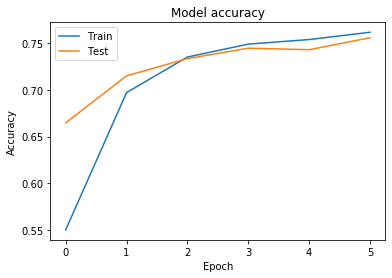

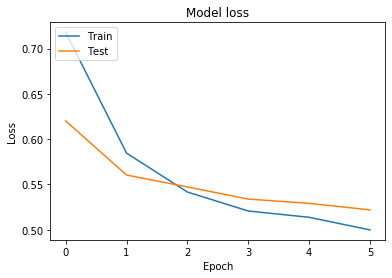

In [12]:
history = model.history

if history:
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()